# Princeton 24bit

## Ausgangspunkt

Ich habe das Signal der Fernbedinung, das ich analysieren mit einem Flipper Zero aufgezeichnet. Dort wird es als Princeton 24bit bezeichnet. Deswegen verwende ich diese Bezeichnung weiter.

Analysieren nutze ich ein RXB6-Modul. Es hat AGC (automatic gain control) und stellt seine Empfangssensitivität automatisch so ein, dass es immer ein Signal empfängt. Ist gerade kein Signal vorhanden, empfängt es Rauschen. Leider ist bei diesem Modul die aktuelle Signalstärke (RSSI) nicht von außen erkennbar. Der DATA-Pin springt also zwischen 1 und 0 hin und her und es ist nicht erkennbar, ob gerade ein tatsächliches Signal empfangen wird, oder nur Rauschen. 

Dieses Signal sieht dann so aus:

Rauschen

![image](./img/RXB6_Scope_Noise.jpeg)

Signal

![image](./img/RXB6_Scope_Signal.jpeg)

Man erkennt also eine gewisse Regelmäßigkeit, wenn ein Signal empfangen wird.

## Analyse

Als erstes habe ich mit einem ESP32 die On/Off-Zeiten gemessen und aufgezeichnet. In der Messung sind 3 Single und viel Rauschen enthalten. Das Ergebnis ist in `sig_princeton24bit.json` zu finden:

```json
[
    [296, 10345], 
    [350, 1744],
    ...
]
```

Die erste Zahl ist immer die Dauer des High-Signals, die zweite die Dauer des Low-Signals.

Als nächstes habe ich die Punkte in einem Diagramm dargestellt:

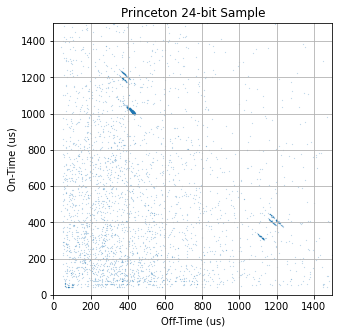

In [7]:
import json
from matplotlib import pyplot as plt

raw_data = []
with open('sig_princeton24bit_sample.json', 'r') as f:
    raw_data = json.load(f)

x = [p[0] for p in raw_data]
y = [p[1] for p in raw_data]

fig, ax = plt.subplots()
ax.scatter(x,y, s=.01)
fig.set_size_inches(5, 5)
ax.set_xlim(0, 1500)
ax.set_ylim(0, 1500)
ax.set_xlabel('Off-Time (us)')
ax.set_ylabel('On-Time (us)')
ax.set_title('Princeton 24-bit Sample')
ax.grid(True)

Man erkennt ein paar Häufungen. Das ist das tatsächliche Signal, der Rest ist Rauschen. 

Es sieht so aus, als ob sich die Punktewolken auf 3 Linien verteilen. Wenn man auf der x-Achse die Zykluszeit (On- + Off-Time) darstellt, ergibt sich folgendes Bild:

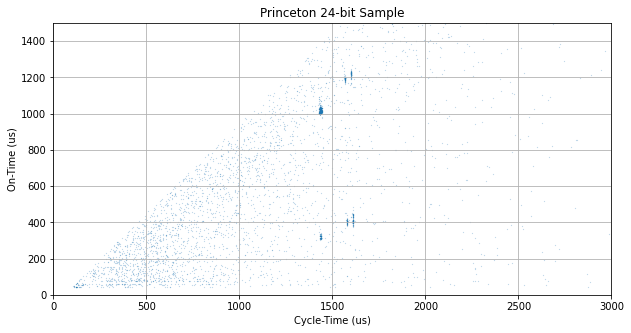

In [9]:
cycle_time = [p[0] + p[1] for p in raw_data]
t_on = [p[1] for p in raw_data]

fig, ax = plt.subplots()
ax.scatter(cycle_time,t_on, s=.01)
fig.set_size_inches(10, 5)
ax.set_xlim(0, 3000)
ax.set_ylim(0, 1500)
ax.set_xlabel('Cycle-Time (us)')
ax.set_ylabel('On-Time (us)')
ax.set_title('Princeton 24-bit Sample')
ax.grid(True)

Hier erkennt man, dass die einzelnen Signale jeweils eine konstante Zykluszeit haben. 1 und 0 wird dabei durch die On-/Off-Zeit kodiert.
Allerdings ist die Zykluszeit nicht konstant. Sie bewegt sich um 1500 us. Wenn ich also einige On-/Off-Sprünge mit einer mehr oder weniger konstanten Zykluszeit empfange, kann ich mir recht sicher sein, dass ich hier ein Signal empfangen habe.

Dieses Signal kann ich jetzt in meinem Sample suchen:

In [10]:
def find_signals(sample):
    cycle_time = 0
    last_cycle_time = 0
    # acceptable tolerance for cycle time
    tolerance = 100
    cntr = 0
    signals = []
    for i, point in enumerate(sample):
        cycle_time = point[0] + point[1]
        if abs(cycle_time - last_cycle_time) < tolerance:
            cntr += 1
        else:
            # only accept signals that are 20 cycles or longer
            if cntr > 20:
                signals.append((i-cntr, i, cntr))
            cntr = 1
        last_cycle_time = cycle_time

    return signals

signals = find_signals(raw_data)
signals

[(641, 665, 24),
 (666, 690, 24),
 (691, 715, 24),
 (1202, 1226, 24),
 (1227, 1251, 24),
 (1252, 1276, 24),
 (1277, 1299, 22),
 (2030, 2054, 24),
 (2055, 2079, 24),
 (2080, 2104, 24),
 (2105, 2129, 24),
 (2130, 2154, 24),
 (2155, 2179, 24),
 (2180, 2204, 24),
 (2205, 2229, 24),
 (2230, 2254, 24),
 (2571, 2594, 23),
 (2595, 2619, 24),
 (2620, 2644, 24),
 (2645, 2669, 24),
 (2670, 2694, 24),
 (2723, 2747, 24),
 (2748, 2772, 24),
 (2773, 2797, 24),
 (2942, 2966, 24),
 (2967, 2991, 24),
 (2992, 3016, 24),
 (3017, 3041, 24),
 (3042, 3066, 24),
 (3067, 3091, 24),
 (3092, 3116, 24),
 (3117, 3141, 24),
 (3142, 3166, 24),
 (3523, 3547, 24),
 (3548, 3572, 24),
 (3573, 3597, 24)]

Als nächstes kann ich die Signale interprätieren:
Im Diagramm oben erkennt man 6 Häufungen:

| Cycle-Time | On-Time (0) |  On-Time (1) |
|------------|-------------|--------------|
|     1440us | 330us (23%) | 1020us (71%) |
|     1570us | 400us (25%) | 1180us (75%) |
|     1610us | 410us (25%) | 1220us (76%) |

Ich kann jetzt also in jedem Zyklus messen, wie lange die On-Zeit war und dann entsprechend die logischen Werte zuweisen:

In [21]:
def decode_signal(sample, signal):
    sub_sample = sample[signal[0]:signal[1]]
    value = 0
    for p in sub_sample:
        cycle_time = p[0] + p[1]
        t_on = p[1]
        value <<= 1
        if 0.15*cycle_time < t_on < 0.35*cycle_time:
            value |= 1
        elif 0.65*cycle_time < t_on < 0.85*cycle_time:
            pass
        else:
            return

    return value

for s in signals:
    value = decode_signal(raw_data, s)
    print("0x{:06x}".format(value))

0xf23d54
0xf23d54
0xf23d54
0xf23d54
0xf23d54
0xf23d54
0x3c8f55
0x000014
0x000014
0x000014
0x000014
0x000014
0x000014
0x000014
0x000014
0x000014
0x000015
0x000015
0x000015
0x000015
0x000015
0x000015
0x000015
0x000015
0x000014
0x000014
0x000014
0x000014
0x000014
0x000014
0x000014
0x000014
0x000014
0xf23d54
0xf23d54
0xf23d54


Laut meinem Flipper Zero habe ich die Signale 0x000014, 0x000015 und 0xf23d54 gesendet. Ab und zu habe ich auch mal etwas anderes empfangen. In diesen Fällen sind 1-2 Bit verloren gegangen. Damit muss man bei dieser Art der Signalübertragung wohl rechnen.